In [5]:
import numpy as np
import pandas as pd
import sqlite3 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from datasets import Dataset, DatasetDict
from transformers import AutoConfig, AutoModelForCausalLM,AutoTokenizer,BitsAndBytesConfig
from stripedhyena.tokenizer import CharLevelTokenizer
import torch

In [6]:
RANDOM = 42
out_path = './processed_data'
model_path = './evo-1-8k-base'

## Combine datasets

In [7]:
#Combine dataset
mega_dG_df_lst = []
mega_dG_path = './Processed_K50_dG_datasets'
for i in os.listdir(mega_dG_path):
    if i[:5] == 'Tsubo':
        path = os.path.join(mega_dG_path,i)
        df = pd.read_csv(path)
        mega_dG_df_lst.append(df)

mega_dG_df = pd.concat(mega_dG_df_lst)
print(mega_dG_df.shape)

/tmp/ipykernel_5107/3648225863.py:7: DtypeWarning: Columns (30,31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


(2617583, 37)


In [8]:
mega_dG_df

,name,dna_seq,log10_K50_t,log10_K50_t_95CI_high,log10_K50_t_95CI_low,log10_K50_t_95CI,fitting_error_t,log10_K50unfolded_t,deltaG_t,deltaG_t_95CI_high,...,aa_seq,mut_type,WT_name,WT_cluster,log10_K50_trypsin_ML,log10_K50_chymotrypsin_ML,dG_ML,ddG_ML,Stabilizing_mut,pair_name
0,EA|run2_0325_0005.pdb,TCTGCTGGCGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,1.227105,1.255092,1.197643,0.057449,0.063626,-0.997071,2.998711,3.038485,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2271050771597385,1.2135682995736825,3.3321258839433834,0.01719762915616707,False,NaN
1,EA|run2_0325_0005.pdb_wtm,TCCGCGGGTGGTTCCGCTGGCGGTTCTGCGGGCGGTGACGAAGTTA...,1.297559,1.381800,1.243835,0.137965,0.092264,-0.997071,3.099109,3.220506,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2975591020191513,1.2201805304541726,3.3998316632160224,0.08490340842880606,False,NaN
2,EA|run2_0325_0005.pdb_wte,TCCGCTGGTGGCTCTGCGGGCGGTTCTGCTGGTGGCGACGAAGTTA...,1.262708,1.314787,1.239876,0.074911,0.092305,-0.997071,3.049332,3.123805,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2627076164958364,1.169472475788951,3.315782210420261,0.0008539556330444675,False,NaN
3,EA|run2_0325_0005.pdb_wty,TCCGCTGGTGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,1.244782,1.314467,1.195005,0.119462,0.074537,-0.997071,3.023818,3.123346,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,1.2447822859698547,1.1543165166325822,3.272933265369934,-0.04199498941728219,False,NaN
4,EA|run2_0325_0005.pdb_wth,TCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCG...,0.998142,1.134508,0.723845,0.410663,0.315576,-1.010140,2.694897,2.885558,...,DEVTIHLGDKTIRVDGLDKELLEILKELARRGADEEELRKEIERWER,wt,EA|run2_0325_0005.pdb,EEHH,0.9981417661631856,0.6573573370630326,2.570241917260095,-0.7446863375271211,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841280,5GHB.pdb_I68C,TCCGCGGGTGGTCACATCAACCTGAAAGTTGCGGGTCAGGACGGTT...,-0.659227,-0.592633,-0.713220,0.120587,0.063869,-1.675883,1.299455,1.397173,...,NaN,NaN,NaN,NaN,-0.6592273716286323,-2.32007634084457,NaN,NaN,NaN,NaN
1841281,5GHB.pdb_D69C,TCTGCTGGCGGTCACATCAACCTGAAAGTTGCGGGTCAGGACGGTT...,1.526104,1.553159,1.500452,0.052707,0.064731,-1.690861,4.361019,4.401617,...,NaN,NaN,NaN,NaN,1.5261042575493224,0.2675031199165091,NaN,NaN,NaN,NaN
1841282,5GHB.pdb_V70C,TCTGCTGGCGGTCACATTAACCTGAAAGTTGCGGGTCAGGACGGCT...,0.189385,0.213863,0.152034,0.061828,0.102480,-1.678700,2.489757,2.523049,...,NaN,NaN,NaN,NaN,0.1893847673240727,-0.9724388178041864,NaN,NaN,NaN,NaN
1841283,5GHB.pdb_F71C,TCCGCTGGCGGCCATATCAACCTGAAAGTTGCGGGTCAGGACGGTT...,1.406698,1.424117,1.375079,0.049039,0.073401,-1.670525,4.157925,4.183294,...,NaN,NaN,NaN,NaN,1.4066979508059534,0.0777885370976122,NaN,NaN,NaN,NaN


## Process dataset

In [9]:
#No. of preprocessed, valid dG values
# "-" are unreliable data determined by dataset authorss
print(len(mega_dG_df[mega_dG_df['dG_ML'].notna()]))
processed_df = mega_dG_df[['dna_seq','dG_ML','WT_name']].dropna()
processed_df = processed_df[processed_df['dG_ML']!='-']#Seq with invalid dG
processed_df

776298


,dna_seq,dG_ML,WT_name
0,TCTGCTGGCGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,3.3321258839433834,EA|run2_0325_0005.pdb
1,TCCGCGGGTGGTTCCGCTGGCGGTTCTGCGGGCGGTGACGAAGTTA...,3.3998316632160224,EA|run2_0325_0005.pdb
2,TCCGCTGGTGGCTCTGCGGGCGGTTCTGCTGGTGGCGACGAAGTTA...,3.315782210420261,EA|run2_0325_0005.pdb
3,TCCGCTGGTGGCTCCGCGGGTGGTTCCGCTGGTGGTGACGAAGTTA...,3.272933265369934,EA|run2_0325_0005.pdb
4,TCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCGGCTCCGCTGGCG...,2.570241917260095,EA|run2_0325_0005.pdb
...,...,...,...
776293,TCCGCGGGTGGCTCTGCTGGCGGCAACCAGGCGTCTGTTGTTGCGA...,<-1,9AME.pdb
776294,TCCGCGGGTGGTTCTGCGGGCGGTAATCAGGCGTCTGTTGTTGCGA...,<-1,9AME.pdb
776295,TCTGCGGGCGGTTCTGCTGGTGGTAACCAGGCGTCTGTTGTTGCGA...,<-1,9AME.pdb
776296,TCCGCGGGTGGCTCCGCTGGTGGTAATCAGGCGTCTGTTGTTGCGA...,<-1,9AME.pdb


In [10]:
print(processed_df['WT_name'].str[:4].nunique())

274


In [11]:
#Replaced unstable/very stable proteins with numerical representation, change dtype from str to float32
processed_df['dG_ML']=processed_df['dG_ML'].replace('<-1','-1.0')
processed_df['dG_ML']=pd.to_numeric(processed_df['dG_ML'].replace('>5','5.0'))

## Visualizations

Text(0.5, 1.0, 'sequence length distribution')

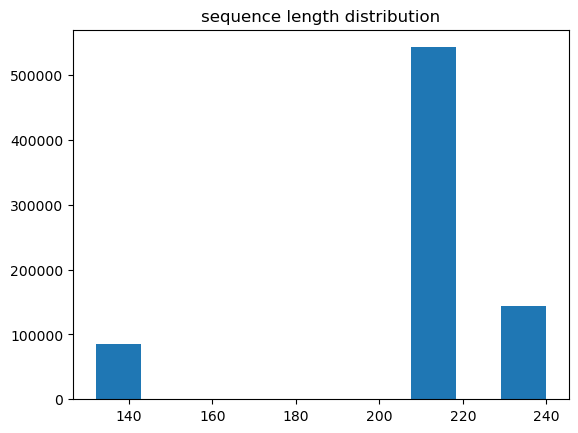

In [12]:
plt.hist(processed_df['dna_seq'].apply(len))
plt.title('sequence length distribution')

Text(0.5, 1.0, 'score distribution')

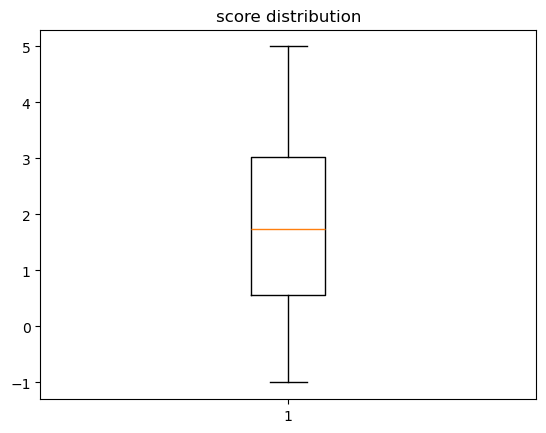

In [13]:
plt.boxplot(processed_df['dG_ML'])
plt.title('score distribution')

In [14]:
tst_ratio = 0.3
r_state = 42
split1 = StratifiedShuffleSplit(n_splits=1,test_size=tst_ratio,random_state = r_state)
s = split1.split(processed_df,processed_df['WT_name'])

In [15]:
processed_df.columns

Index(['dna_seq', 'dG_ML', 'WT_name'], dtype='object')

In [16]:
#Get Max length of dna sequence
max_length = processed_df['dna_seq'].str.len().max()

In [17]:
max_length 

240

## Embedding

In [18]:
from stripedhyena.tokenizer import CharLevelTokenizer

tokenizer = CharLevelTokenizer(512)

#Code copied and then modified from official EVO repo
def prepare_batch(
    seqs: [str],
    tokenizer: CharLevelTokenizer,
    prepend_bos: bool = True,
    device: str = 'cuda:0'
) -> [torch.Tensor, [int]]:
    """
    Takes in a list of sequences, tokenizes them, and puts them in a tensor batch.
    If the sequences have differing lengths, then pad up to the maximum sequence length.
    """
    seq_lengths = [ len(seq) for seq in seqs ]
    max_seq_length = max(seq_lengths)

    input_ids = []
    for seq in seqs:
        padding = [tokenizer.pad_id] * (max_seq_length - len(seq))
        input_ids.append(
            torch.tensor(
                ([tokenizer.eod_id] * int(prepend_bos)) + tokenizer.tokenize(seq) + padding,
                dtype=torch.long,
            ).to(device).unsqueeze(0)
        )
    input_ids = torch.cat(input_ids, dim=0)

    return input_ids, seq_lengths
#token_dsets = datasets.map(tokenize_data)

In [19]:
tokenizer.tokenize('\x01')

[1]

## Split

In [21]:
#Stratified split on wild type (non mutated), hence separation of similar proteins

tst_ratio = 0.3
split1 = StratifiedShuffleSplit(n_splits=1,test_size=tst_ratio,random_state = RANDOM)
split2 = StratifiedShuffleSplit(n_splits=1,test_size=0.5,random_state = RANDOM)
for train, test in split1.split(processed_df,processed_df['WT_name']):
    train_dset = processed_df.iloc[train][['dna_seq','dG_ML']]
    tv_dset = processed_df.iloc[test]

for val, test in split2.split(tv_dset,tv_dset['WT_name']):
    val_dset = tv_dset.iloc[val][['dna_seq','dG_ML']]
    test_dset = tv_dset.iloc[test][['dna_seq','dG_ML']]

In [22]:
#train_dset['dna_seq'] = prepare_batch(train_dset['dna_seq'].tolist(),tokenizer)[0].tolist()
#test_dset['dna_seq'] = prepare_batch(test_dset['dna_seq'].tolist(),tokenizer)[0].tolist()
#val_dset['dna_seq'] = prepare_batch(val_dset['dna_seq'].tolist(),tokenizer)[0].tolist()

train_dataset = Dataset.from_pandas(train_dset.rename(columns={"dG_ML": "labels"}))
test_dataset = Dataset.from_pandas(test_dset.rename(columns={"dG_ML": "labels"}))
val_dataset = Dataset.from_pandas(val_dset.rename(columns={"dG_ML": "labels"}))

# Combine into a DatasetDict
datasets = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'val': val_dataset
})
datasets = datasets.remove_columns(['__index_level_0__'])

In [23]:
len(train_dataset)

540232

In [21]:
len(test_dataset)

115765

In [24]:
datasets.save_to_disk('./processed_data')

Saving the dataset (0/1 shards):   0%|          | 0/540232 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/115765 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/115764 [00:00<?, ? examples/s]

In [ ]:
tokenize_function(datasets['train'][0])

In [ ]:
len(tokenizer.tokenize(datasets['train'][0]['dna_seq']))

In [ ]:
train_dset['dna_seq']

In [ ]:
input_id

In [ ]:
len(tokenizer.detokenize_batch(input_id))



In [ ]:
if not os.path.exists("./model_data/"):
    os.makedirs("./model_data/")
train_dset.to_csv("./model_data/train_dset.csv")
val_dset.to_csv("./model_data/val_dset.csv")
test_dset.to_csv("./model_data/test_dset.csv")